In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns

from adaptive_time.utils import set_directory_in_project

from importlib import reload
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

from pprint import pprint

sns.set_style("darkgrid")
sns.set_palette("colorblind")

In [23]:
def set_size(width_pt, fraction=1, subplots=(1, 1), use_golden_ratio=True):
    """
    Reference: https://jwalton.info/Matplotlib-latex-PGF/
    Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    if use_golden_ratio:
        # Golden ratio to set aesthetic figure height
        golden_ratio = (5**0.5 - 1) / 2

        # Figure height in inches
        fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])
    else:
        fig_height_in = fig_width_in * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


# pgf_with_latex = {  # setup matplotlib to use latex for output
#     "pgf.texsystem": "pdflatex",  # change this if using xetex or lautex
#     "text.usetex": True,  # use LaTeX to write all text
#     "font.family": "serif",
#     "font.serif": [],  # blank entries should cause plots to inherit fonts from the document
#     "font.sans-serif": [],
#     "font.monospace": [],
#     "axes.labelsize": 10,  # LaTeX default is 10pt font.
#     "font.size": 10,
#     "legend.fontsize": 8,  # Make the legend/label fonts a little smaller
#     "xtick.labelsize": 8,
#     "ytick.labelsize": 8,
#     "pgf.rcfonts": False,  # don't setup fonts from rc parameters
#     "text.latex.preamble": r"\usepackage{amsmath}",
# }

# # But with fonts from the document body
# plt.rcParams.update(pgf_with_latex)

# Using the set_size function as defined earlier
# doc_width_pt = 452.9679

In [3]:
from adaptive_time import plot_utils
from adaptive_time import utils
from adaptive_time import run_lib
from adaptive_time import value_est
from adaptive_time.value_est import approx_integrators

approx_integrators = reload(approx_integrators)
run_lib = reload(run_lib)
value_est = reload(value_est)
plot_utils = reload(plot_utils)
utils = reload(utils)

In [4]:
set_directory_in_project()
data_dir = "./data"
# data_dir = "./smoothed_data"
env_names = [env_name for env_name in os.listdir(data_dir) if not env_name.startswith(".DS_Store")]
print(env_names)

Changed working directory to /home/bryanpu1/projects/adaptive_time
['hopper-v3', 'swimmer-v3', 'pusher-v2', 'cheetah-v3', 'inverted_double_pendulum-v2', 'ant-v3']


In [5]:
# prefixes = ["uniform", "adaptive"]
prefixes = ["uniform-smoothed_data", "adaptive-smoothed_data", "uniform", "adaptive"]
# prefixes = ["uniform-smoothed_data", "adaptive-smoothed_data"]
# prefixes = ["uniform"]

agg_results_per_prefix = {}
samplers_per_prefix = {}
for prefix in prefixes:
    if prefix.startswith("uniform"):
        sampler_constructor = approx_integrators.UniformlySpacedIntegrator
    elif prefix.startswith("adaptive"):
        sampler_constructor = approx_integrators.AdaptiveQuadratureIntegrator
    else:
        raise NotImplementedError
    agg_results_per_prefix[prefix] = pickle.load(open("./{}-combined_mujoco_val_est.pkl".format(prefix), "rb"))
    samplers_per_prefix[prefix] = {
        hyperparam: sampler_constructor(hyperparam) for hyperparam in agg_results_per_prefix[prefix]["ant-v3"]["approx_integrals"]
    }

# Sample trajectories and estimate values

In [6]:
# pprint([(env_name, data["true_value"]) for env_name, data in est_results["adaptive"].items() if env_name not in ["pusher-v2", "inverted_double_pendulum-v2"]])

In [7]:
update_budget = 1_000_000
sample_block = 1_000_000
num_seeds = 10

est_results = {}

for prefix, agg_results in agg_results_per_prefix.items():
    print(prefix)

    agg_prefix = prefix.split("-")[0]
    est_results.setdefault(agg_prefix, {})
    samplers_tried = samplers_per_prefix[prefix]

    print(agg_prefix)
    print(agg_results.keys())

    for env_name in agg_results:
        if not prefix.endswith("-smoothed_data") and env_name not in ["pusher-v2", "inverted_double_pendulum-v2"]:
            continue
        vals_per_state = np.concatenate(
            [np.sum(np.load(reward_file).T, axis=-1) for reward_file in agg_results[env_name]["reward_file"]]
        )
        print([reward_file for reward_file in agg_results[env_name]["reward_file"]])
        print(vals_per_state.shape)

        approx_integrals = agg_results[env_name]["approx_integrals"]
        num_pivots = agg_results[env_name]["num_pivots"]

        weights = np.ones(len(vals_per_state)) / len(vals_per_state)
        true_value = np.sum(weights * vals_per_state)

        est_results[agg_prefix][env_name] = {
            "weights": weights,
            "true_value": true_value,
            "runs": []
        }

        for seed in tqdm(range(num_seeds)):
            estimated_values_by_episode = {}
            number_of_pivots_by_episode = {}
            all_values_by_episode = {}

            rng = np.random.RandomState(seed)
            start_states = rng.choice(len(vals_per_state), p=weights, size=(update_budget))

            for sampler_name, sampler in samplers_tried.items():
                # print("sampler_name:", sampler_name)
                # Update the value estimate with new samples until we run out of budget.
                used_updates = 0
                value_estimate = 0
                num_episodes = 0
                all_values_by_episode[sampler_name] = []

                estimated_values_by_episode[sampler_name] = []
                number_of_pivots_by_episode[sampler_name] = []

                # pbar = tqdm(total = update_budget)
                while used_updates < update_budget:
                    num_episodes += 1
                    if num_episodes % sample_block == 0:
                        start_states = rng.choice(len(vals_per_state), p=weights, size=(update_budget))
                    start_state = start_states[(num_episodes - 1) % sample_block]
                    val_sample = approx_integrals[sampler_name][start_state]
                    all_values_by_episode[sampler_name].append(val_sample)
                    
                    value_estimate += (1.0/num_episodes) * (val_sample - value_estimate)
                    used_updates += num_pivots[sampler_name][start_state]

                    estimated_values_by_episode[sampler_name].append(value_estimate)
                    number_of_pivots_by_episode[sampler_name].append(used_updates)
                #     pbar.update(num_pivots[sampler_name][start_state])
                # pbar.close()
            est_results[agg_prefix][env_name]["runs"].append({
                "estimated_values_by_episode": estimated_values_by_episode,
                "number_of_pivots_by_episode": number_of_pivots_by_episode,
                "all_values_by_episode": all_values_by_episode,
            })
        print(est_results[agg_prefix].keys())


uniform-smoothed_data
uniform
dict_keys(['swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3'])
['./smoothed_data/swimmer-v3/Rewards_40000_1000_0-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_7-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_6-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_1-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_8-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_9-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_3-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_4-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_5-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_2-smoothed.npy']
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['swimmer-v3'])
['./smoothed_data/hopper-v3/Rewards_50000_1000_9-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_8-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_2-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_5-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_4-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_3-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_1-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_6-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_7-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_0-smoothed.npy']
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['swimmer-v3', 'hopper-v3'])
['./smoothed_data/ant-v3/Rewards_50000_1000_9-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_8-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_2-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_5-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_4-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_3-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_1-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_6-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_7-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_0-smoothed.npy']
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['swimmer-v3', 'hopper-v3', 'ant-v3'])
['./smoothed_data/cheetah-v3/Rewards_50000_1000_9-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_8-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_2-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_5-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_4-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_3-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_1-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_6-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_7-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_0-smoothed.npy']
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3'])
adaptive-smoothed_data
adaptive
dict_keys(['swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3'])
['./smoothed_data/swimmer-v3/Rewards_40000_1000_0-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_7-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_6-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_1-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_8-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_9-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_3-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_4-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_5-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_2-smoothed.npy']
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['swimmer-v3'])
['./smoothed_data/hopper-v3/Rewards_50000_1000_9-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_8-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_2-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_5-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_4-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_3-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_1-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_6-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_7-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_0-smoothed.npy']
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['swimmer-v3', 'hopper-v3'])
['./smoothed_data/ant-v3/Rewards_50000_1000_9-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_8-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_2-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_5-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_4-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_3-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_1-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_6-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_7-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_0-smoothed.npy']
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['swimmer-v3', 'hopper-v3', 'ant-v3'])
['./smoothed_data/cheetah-v3/Rewards_50000_1000_9-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_8-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_2-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_5-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_4-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_3-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_1-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_6-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_7-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_0-smoothed.npy']
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3'])
uniform
uniform
dict_keys(['inverted_double_pendulum-v2', 'swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3', 'pusher-v2'])
['./data/inverted_double_pendulum-v2/Rewards_50000_1000_9.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_8.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_6.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_7.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_5.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_4.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_0.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_1.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_3.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_2.npy']
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3', 'inverted_double_pendulum-v2'])
['./data/pusher-v2/Rewards_50000_1000_9.npy', './data/pusher-v2/Rewards_50000_1000_8.npy', './data/pusher-v2/Rewards_50000_1000_6.npy', './data/pusher-v2/Rewards_50000_1000_7.npy', './data/pusher-v2/Rewards_50000_1000_5.npy', './data/pusher-v2/Rewards_50000_1000_4.npy', './data/pusher-v2/Rewards_50000_1000_0.npy', './data/pusher-v2/Rewards_50000_1000_1.npy', './data/pusher-v2/Rewards_50000_1000_3.npy', './data/pusher-v2/Rewards_50000_1000_2.npy']
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3', 'inverted_double_pendulum-v2', 'pusher-v2'])
adaptive
adaptive
dict_keys(['inverted_double_pendulum-v2', 'swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3', 'pusher-v2'])
['./data/inverted_double_pendulum-v2/Rewards_50000_1000_9.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_8.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_6.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_7.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_5.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_4.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_0.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_1.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_3.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_2.npy']
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3', 'inverted_double_pendulum-v2'])
['./data/pusher-v2/Rewards_50000_1000_9.npy', './data/pusher-v2/Rewards_50000_1000_8.npy', './data/pusher-v2/Rewards_50000_1000_6.npy', './data/pusher-v2/Rewards_50000_1000_7.npy', './data/pusher-v2/Rewards_50000_1000_5.npy', './data/pusher-v2/Rewards_50000_1000_4.npy', './data/pusher-v2/Rewards_50000_1000_0.npy', './data/pusher-v2/Rewards_50000_1000_1.npy', './data/pusher-v2/Rewards_50000_1000_3.npy', './data/pusher-v2/Rewards_50000_1000_2.npy']
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3', 'inverted_double_pendulum-v2', 'pusher-v2'])


# Compile plot statistics using interpolation

In [8]:
def process_across_runs(
    runs,
    samplers_tried,
    true_value,
):
    results = {}
    for sampler in samplers_tried:
        interpolated_results = np.zeros((len(runs), update_budget + 1))
        for run_i, run in enumerate(runs):
            number_of_pivots_by_episode = run["number_of_pivots_by_episode"][sampler]
            estimated_values_by_episode = run["estimated_values_by_episode"][sampler]

            interpolated_results[run_i] = np.interp(
                np.arange(update_budget + 1),
                number_of_pivots_by_episode,
                np.abs(estimated_values_by_episode - true_value)[:number_of_pivots_by_episode[-1]]
            )
        results[sampler] = interpolated_results
    return results

In [9]:
print(est_results["adaptive"].keys(), est_results["uniform"].keys())

dict_keys(['swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3', 'inverted_double_pendulum-v2', 'pusher-v2']) dict_keys(['swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3', 'inverted_double_pendulum-v2', 'pusher-v2'])


In [10]:
print(est_results.keys())

dict_keys(['uniform', 'adaptive'])


In [11]:

plot_stats = {}
for prefix, curr_result in est_results.items():
    print(prefix)
    # samplers_tried = samplers_per_prefix["{}-smoothed_data".format(prefix)]
    samplers_tried = samplers_per_prefix[prefix]
    plot_stats[prefix] = {}
    for env_i, env_name in enumerate(tqdm(curr_result)):
        true_value = curr_result[env_name]["true_value"]
        env_result = process_across_runs(
            curr_result[env_name]["runs"],
            samplers_tried,
            true_value
        )
        plot_stats[prefix][env_name] = env_result

uniform


  0%|          | 0/6 [00:00<?, ?it/s]

adaptive


  0%|          | 0/6 [00:00<?, ?it/s]

# Plot error vs number of updates

## Plot aggregated result

In [12]:
# s_to_plot = ["q1", "q10", "q100", "u1", "u10", "u500"]
# s_to_plot = ["q0", "u1"]
# s_to_plot = samplers_tried.keys()
plot_this = False
if plot_this:
    ncols = 3
    fig, axes = plt.subplots(nrows=len(env_names) // ncols, ncols=ncols, figsize=(15, 8), layout="constrained")

    start_idx = 0
    end_idx = 1_000_000
    for env_i, env_name in enumerate(env_names):
        ax = axes[env_i // ncols, env_i % ncols]
        for prefix in prefixes:
            env_result = plot_stats[prefix][env_name]
            samplers_tried = samplers_per_prefix[prefix]
            for s in tqdm(samplers_tried):
                y_means = np.nanmean(env_result[s][:, start_idx:end_idx], axis=0)
                y_stderrs = np.nanstd(env_result[s][:, start_idx:end_idx], axis=0) / np.sqrt(num_seeds)
                x_range = np.arange(update_budget + 1)[start_idx:end_idx]

                y_means = np.log10(y_means, out=np.zeros_like(y_means), where=(y_means != 0))
                y_stderrs = np.log10(y_stderrs, out=np.zeros_like(y_stderrs), where=(y_stderrs != 0))

                ax.plot(
                    x_range,
                    y_means,
                    label=s if env_i == 0 else ""
                )
                ax.fill_between(
                    x_range,
                    (y_means - y_stderrs),
                    (y_means + y_stderrs),
                    alpha=0.1
                )
        ax.set_title("Env: {}".format(env_name))

    fig.supylabel("Error in value estimate")
    fig.supxlabel("Number of Samples")
    fig.legend()
    plt.show()

# Plot error vs hyperparameter (i.e. tolerance/discretization)

In [13]:
budgets_to_check_per_env = {
    "inverted_double_pendulum-v2": (25000, np.array([1, 2, 5, 10, 20, 40])),
    "swimmer-v3": (20000, np.array([1, 2, 5, 10, 20, 40])),
    "hopper-v3": (8000, np.array([1, 2, 5, 10, 20, 40])),
    "ant-v3": (25000, np.array([1, 2, 5, 10, 20, 40])),
    "cheetah-v3": (25000, np.array([1, 2, 5, 10, 20, 40])),
    "pusher-v2": (25000, np.array([1, 2, 5, 10, 20, 40])),
}

map_env = {
    "inverted_double_pendulum-v2": "Inverted Double Pendulum",
    "swimmer-v3": "Swimmer",
    "hopper-v3": "Hopper",
    "ant-v3": "Ant",
    "cheetah-v3": "Half Cheetah",
    "pusher-v2": "Pusher",
}

In [69]:
adaptive_prefix = "adaptive-smoothed_data"

tolerances = np.power(10, np.arange(-2.0, 4.0, 1.0)) * 5
samplers_tried = {
    "q{}".format(tolerance): approx_integrators.AdaptiveQuadratureIntegrator(tolerance=tolerance) for tolerance in tolerances
}

tau_to_h = {}
for env_i, env_name in enumerate(env_names):
    traj_len = 40000 if env_name == "swimmer-v3" else 50000
    prefix = adaptive_prefix.split("-")[0] if env_name in ["pusher-v2", "inverted_double_pendulum-v2"] else adaptive_prefix
    print(prefix, adaptive_prefix, env_name)
    env_result = plot_stats[adaptive_prefix.split("-")[0]][env_name]
    num_pivots = agg_results_per_prefix[prefix][env_name]["num_pivots"]
    tau_to_h[env_name] = np.array([
        (sampler, (np.mean(traj_len / (num_pivots[sampler] - 1)))) for sampler in num_pivots
    ])

adaptive-smoothed_data adaptive-smoothed_data hopper-v3
adaptive-smoothed_data adaptive-smoothed_data swimmer-v3
adaptive adaptive-smoothed_data pusher-v2
adaptive-smoothed_data adaptive-smoothed_data cheetah-v3
adaptive adaptive-smoothed_data inverted_double_pendulum-v2
adaptive-smoothed_data adaptive-smoothed_data ant-v3


# Visualize Tolerance vs Pivots

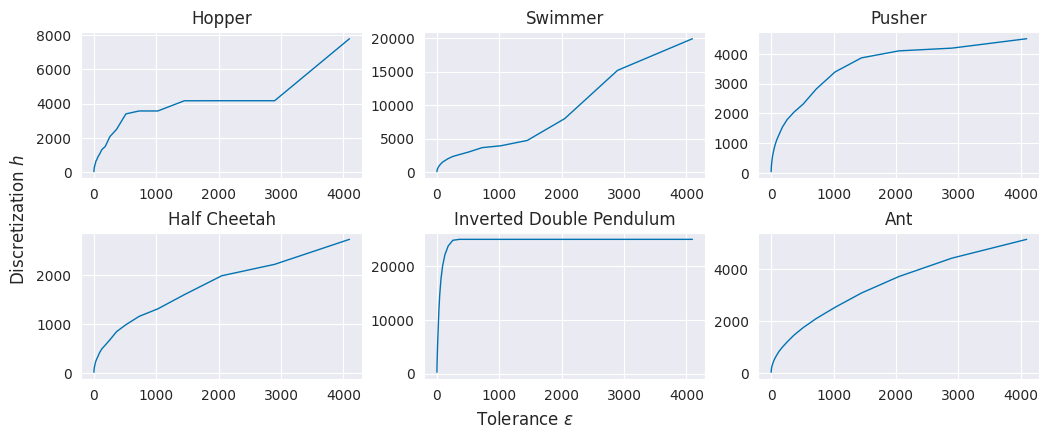

In [85]:
doc_width_pt = 750.0
ncols = 3
nrows = len(env_names) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=set_size(doc_width_pt, 1.0, (nrows, ncols)), layout="constrained")

for env_i, env_name in enumerate(env_names):
    ax = axes[env_i // ncols, env_i % ncols]
    res = np.array([(float(sampler[1:]), float(discretization)) for (sampler, discretization) in tau_to_h[env_name]])
    sort_idxes = np.argsort(res.T[0])
    ax.plot(res.T[0][sort_idxes], res.T[1][sort_idxes], linewidth=1)
    ax.set_title(map_env[env_name])

fig.supylabel("Discretization $h$")
fig.supxlabel("Tolerance $\\varepsilon$")

# plt.show()
plt.savefig("tol_vs_disc.pdf", dpi=600, format="pdf", bbox_inches="tight")

# Uniform vs Adaptive Methods with Mapped Tolerance

hopper-v3
8000
[['q0.125' '40.141971536646714']
 ['q0.1767766952966369' '45.790875965516356']
 ['q0.25' '55.29503752562255']
 ['q0.3535533905932738' '64.80970605319627']
 ['q0.5' '80.07971720521982']
 ['q0.7071067811865476' '91.42743030467756']
 ['q1.0' '109.82231574347264']
 ['q1.4142135623730951' '127.8718385569925']
 ['q2.0' '159.93221566060046']
 ['q2.8284271247461903' '179.93944579964048']
 ['q4.0' '222.78601568160457']
 ['q5.656854249492381' '259.51076107467037']
 ['q8.0' '321.4812446392366']
 ['q11.313708498984761' '360.3414472698652']
 ['q16.0' '434.57864155149673']
 ['q22.627416997969522' '508.2632336445218']
 ['q32.0' '654.5559210526314']
 ['q45.254833995939045' '732.3448826858755']
 ['q64.0' '903.1265227429018']
 ['q90.50966799187809' '1062.0913791321398']
 ['q128.0' '1330.2061403508771']
 ['q181.01933598375618' '1505.5357142857144']
 ['q256.0' '2083.522727272727']
 ['q362.03867196751236' '2500.0']
 ['q512.0' '3401.006944444445']
 ['q1024.0' '3571.4285714285716']
 ['q724.077

  0%|          | 0/6 [00:00<?, ?it/s]

8000
[['u2' '2']
 ['u3' '3']
 ['u4' '4']
 ['u5' '5']
 ['u6' '6']
 ['u8' '8']
 ['u9' '9']
 ['u11' '11']
 ['u13' '13']
 ['u16' '16']
 ['u19' '19']
 ['u22' '22']
 ['u26' '26']
 ['u32' '32']
 ['u38' '38']
 ['u45' '45']
 ['u53' '53']
 ['u64' '64']
 ['u76' '76']
 ['u90' '90']
 ['u107' '107']
 ['u128' '128']
 ['u152' '152']
 ['u181' '181']
 ['u215' '215']
 ['u256' '256']
 ['u304' '304']
 ['u362' '362']
 ['u430' '430']
 ['u512' '512']
 ['u608' '608']
 ['u724' '724']
 ['u861' '861']
 ['u1024' '1024']
 ['u1217' '1217']
 ['u1448' '1448']
 ['u1722' '1722']
 ['u2048' '2048']
 ['u2435' '2435']
 ['u2896' '2896']
 ['u3444' '3444']]


  0%|          | 0/6 [00:00<?, ?it/s]

swimmer-v3
20000
[['q0.125' '52.22527770608684']
 ['q0.1767766952966369' '62.08743204849545']
 ['q0.25' '73.57542061874229']
 ['q0.3535533905932738' '87.40115318489865']
 ['q0.5' '104.9031787611935']
 ['q0.7071067811865476' '124.75874392090556']
 ['q1.0' '147.85307087093545']
 ['q1.4142135623730951' '175.67006882673212']
 ['q2.0' '211.13338079582923']
 ['q2.8284271247461903' '252.05728727614755']
 ['q4.0' '299.67541558302196']
 ['q5.656854249492381' '356.3696246188258']
 ['q8.0' '428.27733088282093']
 ['q11.313708498984761' '509.8342501673637']
 ['q16.0' '605.5043375135066']
 ['q22.627416997969522' '722.2172712714473']
 ['q32.0' '870.444571191847']
 ['q45.254833995939045' '1035.3764937869073']
 ['q64.0' '1230.557642596905']
 ['q90.50966799187809' '1481.800793192091']
 ['q128.0' '1704.8136182445012']
 ['q181.01933598375618' '2010.6855422355425']
 ['q256.0' '2331.1088023088023']
 ['q362.03867196751236' '2611.815873015873']
 ['q512.0' '3000.787301587302']
 ['q724.0773439350247' '3642.7801

  0%|          | 0/6 [00:00<?, ?it/s]

20000
[['u2' '2']
 ['u3' '3']
 ['u4' '4']
 ['u5' '5']
 ['u6' '6']
 ['u8' '8']
 ['u9' '9']
 ['u11' '11']
 ['u13' '13']
 ['u16' '16']
 ['u19' '19']
 ['u22' '22']
 ['u26' '26']
 ['u32' '32']
 ['u38' '38']
 ['u45' '45']
 ['u53' '53']
 ['u64' '64']
 ['u76' '76']
 ['u90' '90']
 ['u107' '107']
 ['u128' '128']
 ['u152' '152']
 ['u181' '181']
 ['u215' '215']
 ['u256' '256']
 ['u304' '304']
 ['u362' '362']
 ['u430' '430']
 ['u512' '512']
 ['u608' '608']
 ['u724' '724']
 ['u861' '861']
 ['u1024' '1024']
 ['u1217' '1217']
 ['u1448' '1448']
 ['u1722' '1722']
 ['u2048' '2048']
 ['u2435' '2435']
 ['u2896' '2896']
 ['u3444' '3444']]


  0%|          | 0/6 [00:00<?, ?it/s]

pusher-v2
25000
[['q0.125' '45.27626210622126']
 ['q0.1767766952966369' '52.49040825435841']
 ['q0.25' '60.931919255207454']
 ['q0.3535533905932738' '71.02749980915692']
 ['q0.5' '82.83444963524866']
 ['q0.7071067811865476' '97.63680893290947']
 ['q1.0' '115.45178564836826']
 ['q1.4142135623730951' '136.53011921897706']
 ['q2.0' '161.45565278346297']
 ['q2.8284271247461903' '192.80939470514394']
 ['q4.0' '231.06689256177526']
 ['q5.656854249492381' '276.1079372162595']
 ['q8.0' '329.11779295655975']
 ['q11.313708498984761' '394.8221113504207']
 ['q16.0' '473.90883899147195']
 ['q22.627416997969522' '568.9870625609357']
 ['q32.0' '672.0740719661076']
 ['q45.254833995939045' '799.0176443364927']
 ['q64.0' '950.3685959205854']
 ['q90.50966799187809' '1118.5366399876696']
 ['q128.0' '1297.7675748756756']
 ['q181.01933598375618' '1544.2008566123268']
 ['q256.0' '1793.4992381055088']
 ['q362.03867196751236' '2036.8238527216263']
 ['q512.0' '2312.8317860115462']
 ['q724.0773439350247' '2823.4

  0%|          | 0/6 [00:00<?, ?it/s]

25000
[['u2' '2']
 ['u3' '3']
 ['u4' '4']
 ['u5' '5']
 ['u6' '6']
 ['u8' '8']
 ['u9' '9']
 ['u11' '11']
 ['u13' '13']
 ['u16' '16']
 ['u19' '19']
 ['u22' '22']
 ['u26' '26']
 ['u32' '32']
 ['u38' '38']
 ['u45' '45']
 ['u53' '53']
 ['u64' '64']
 ['u76' '76']
 ['u90' '90']
 ['u107' '107']
 ['u128' '128']
 ['u152' '152']
 ['u181' '181']
 ['u215' '215']
 ['u256' '256']
 ['u304' '304']
 ['u362' '362']
 ['u430' '430']
 ['u512' '512']
 ['u608' '608']
 ['u724' '724']
 ['u861' '861']
 ['u1024' '1024']
 ['u1217' '1217']
 ['u1448' '1448']
 ['u1722' '1722']
 ['u2048' '2048']
 ['u2435' '2435']
 ['u2896' '2896']
 ['u3444' '3444']]


  0%|          | 0/6 [00:00<?, ?it/s]

cheetah-v3
25000
[['q0.125' '15.356739847946884']
 ['q0.1767766952966369' '17.81950186838436']
 ['q0.25' '21.08329473307456']
 ['q0.3535533905932738' '25.857871533804705']
 ['q0.5' '30.836048761545825']
 ['q0.7071067811865476' '35.65455659880899']
 ['q1.0' '42.14989434093885']
 ['q1.4142135623730951' '51.79599178846634']
 ['q2.0' '61.73658678002481']
 ['q2.8284271247461903' '71.33058839436343']
 ['q4.0' '84.42215401524305']
 ['q5.656854249492381' '103.89474484435283']
 ['q8.0' '123.6626319278951']
 ['q11.313708498984761' '142.828390037393']
 ['q16.0' '169.06359338628152']
 ['q22.627416997969522' '208.30131629274504']
 ['q32.0' '248.0940890018057']
 ['q45.254833995939045' '287.19765812203144']
 ['q64.0' '338.97280680135196']
 ['q90.50966799187809' '416.92136217122186']
 ['q128.0' '495.0171433492292']
 ['q181.01933598375618' '569.2989642775328']
 ['q256.0' '677.552301520732']
 ['q362.03867196751236' '843.5963234074194']
 ['q512.0' '985.1271125926947']
 ['q724.0773439350247' '1154.9220602

  0%|          | 0/6 [00:00<?, ?it/s]

25000
[['u2' '2']
 ['u3' '3']
 ['u4' '4']
 ['u5' '5']
 ['u6' '6']
 ['u8' '8']
 ['u9' '9']
 ['u11' '11']
 ['u13' '13']
 ['u16' '16']
 ['u19' '19']
 ['u22' '22']
 ['u26' '26']
 ['u32' '32']
 ['u38' '38']
 ['u45' '45']
 ['u53' '53']
 ['u64' '64']
 ['u76' '76']
 ['u90' '90']
 ['u107' '107']
 ['u128' '128']
 ['u152' '152']
 ['u181' '181']
 ['u215' '215']
 ['u256' '256']
 ['u304' '304']
 ['u362' '362']
 ['u430' '430']
 ['u512' '512']
 ['u608' '608']
 ['u724' '724']
 ['u861' '861']
 ['u1024' '1024']
 ['u1217' '1217']
 ['u1448' '1448']
 ['u1722' '1722']
 ['u2048' '2048']
 ['u2435' '2435']
 ['u2896' '2896']
 ['u3444' '3444']]


  0%|          | 0/6 [00:00<?, ?it/s]

inverted_double_pendulum-v2
25000
[['q0.125' '240.99287727405476']
 ['q0.1767766952966369' '295.37127288538704']
 ['q0.25' '374.18736957522293']
 ['q0.3535533905932738' '476.96247214972925']
 ['q0.5' '596.1707743444041']
 ['q0.7071067811865476' '748.2935314739107']
 ['q1.0' '947.9263832011171']
 ['q1.4142135623730951' '1185.757079029121']
 ['q2.0' '1544.2955887534413']
 ['q2.8284271247461903' '1985.5132729875818']
 ['q4.0' '2571.2452454853174']
 ['q5.656854249492381' '3275.522498133686']
 ['q8.0' '4309.844530143262']
 ['q11.313708498984761' '5480.771090187218']
 ['q16.0' '7041.781495853552']
 ['q22.627416997969522' '9105.983218097623']
 ['q32.0' '11914.89032543339']
 ['q45.254833995939045' '14749.811131634342']
 ['q64.0' '17519.75513692123']
 ['q90.50966799187809' '20021.193547759394']
 ['q128.0' '22139.230555746715']
 ['q181.01933598375618' '23779.994864612512']
 ['q256.0' '24832.90228174603']
 ['q362.03867196751236' '25000.0']
 ['q2048.0' '25000.0']
 ['q4096.0' '25000.0']
 ['q1024.0'

  0%|          | 0/6 [00:00<?, ?it/s]

25000
[['u2' '2']
 ['u3' '3']
 ['u4' '4']
 ['u5' '5']
 ['u6' '6']
 ['u8' '8']
 ['u9' '9']
 ['u11' '11']
 ['u13' '13']
 ['u16' '16']
 ['u19' '19']
 ['u22' '22']
 ['u26' '26']
 ['u32' '32']
 ['u38' '38']
 ['u45' '45']
 ['u53' '53']
 ['u64' '64']
 ['u76' '76']
 ['u90' '90']
 ['u107' '107']
 ['u128' '128']
 ['u152' '152']
 ['u181' '181']
 ['u215' '215']
 ['u256' '256']
 ['u304' '304']
 ['u362' '362']
 ['u430' '430']
 ['u512' '512']
 ['u608' '608']
 ['u724' '724']
 ['u861' '861']
 ['u1024' '1024']
 ['u1217' '1217']
 ['u1448' '1448']
 ['u1722' '1722']
 ['u2048' '2048']
 ['u2435' '2435']
 ['u2896' '2896']
 ['u3444' '3444']]


  0%|          | 0/6 [00:00<?, ?it/s]

ant-v3
25000
[['q0.125' '24.469214277554922']
 ['q0.1767766952966369' '29.07355397460627']
 ['q0.25' '34.48830218843266']
 ['q0.3535533905932738' '43.53546948829515']
 ['q0.5' '51.4777889557818']
 ['q0.7071067811865476' '60.71138057328437']
 ['q1.0' '71.55202524025717']
 ['q1.4142135623730951' '87.14190638826197']
 ['q2.0' '103.14432958205825']
 ['q2.8284271247461903' '121.66727429671427']
 ['q4.0' '143.4174305974286']
 ['q5.656854249492381' '172.16992579399178']
 ['q8.0' '204.35491550826603']
 ['q11.313708498984761' '241.65344859580267']
 ['q16.0' '285.40478285946585']
 ['q22.627416997969522' '338.6814850274073']
 ['q32.0' '403.6324209342903']
 ['q45.254833995939045' '486.5655878306078']
 ['q64.0' '580.6389901473127']
 ['q90.50966799187809' '693.9315532281522']
 ['q128.0' '839.2960948614605']
 ['q181.01933598375618' '997.9364147547543']
 ['q256.0' '1195.626128278711']
 ['q362.03867196751236' '1450.3716512898152']
 ['q512.0' '1747.511091131404']
 ['q724.0773439350247' '2102.02883192901

  0%|          | 0/6 [00:00<?, ?it/s]

25000
[['u2' '2']
 ['u3' '3']
 ['u4' '4']
 ['u5' '5']
 ['u6' '6']
 ['u8' '8']
 ['u9' '9']
 ['u11' '11']
 ['u13' '13']
 ['u16' '16']
 ['u19' '19']
 ['u22' '22']
 ['u26' '26']
 ['u32' '32']
 ['u38' '38']
 ['u45' '45']
 ['u53' '53']
 ['u64' '64']
 ['u76' '76']
 ['u90' '90']
 ['u107' '107']
 ['u128' '128']
 ['u152' '152']
 ['u181' '181']
 ['u215' '215']
 ['u256' '256']
 ['u304' '304']
 ['u362' '362']
 ['u430' '430']
 ['u512' '512']
 ['u608' '608']
 ['u724' '724']
 ['u861' '861']
 ['u1024' '1024']
 ['u1217' '1217']
 ['u1448' '1448']
 ['u1722' '1722']
 ['u2048' '2048']
 ['u2435' '2435']
 ['u2896' '2896']
 ['u3444' '3444']]


  0%|          | 0/6 [00:00<?, ?it/s]

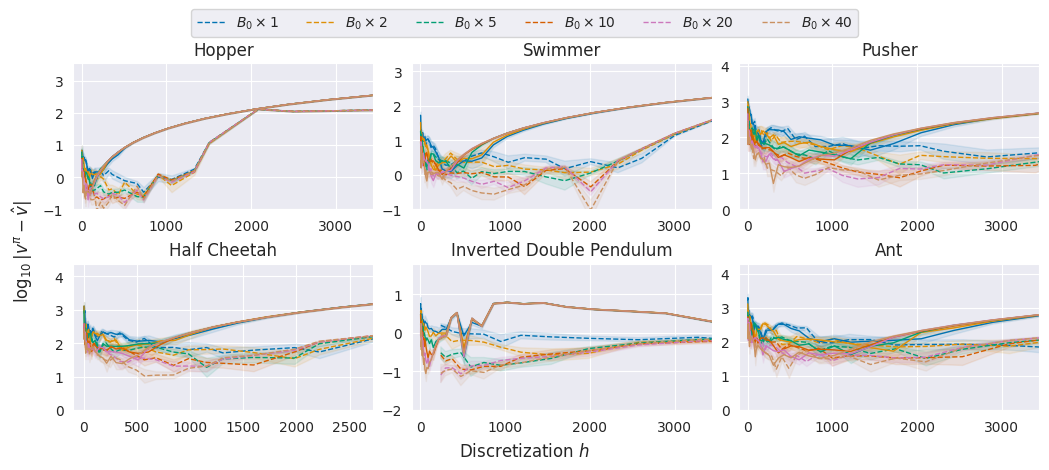

In [88]:
doc_width_pt = 750.0
ncols = 3
nrows = len(env_names) // ncols
# fig, axes = plt.subplots(nrows=len(env_names) // ncols, ncols=ncols, figsize=(15, 8), layout="constrained")
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=set_size(doc_width_pt, 1.0, (nrows, ncols)), layout="constrained")

for env_i, env_name in enumerate(env_names):
    print(env_name)
    min_spacing = np.inf
    max_err = 0.0
    for sampler_type_i, prefix in enumerate(["adaptive", "uniform"]):
    # for prefix in ["adaptive"]:
        if prefix.startswith("uniform"):
            spacing_keys = np.array(list(samplers_per_prefix[prefix].keys()))
            # spacing_keys = np.array(list(samplers_per_prefix["{}-smoothed_data".format(prefix)].keys()))
            spacing = np.array([int(key[1:]) for key in spacing_keys])
            sorted_idxes = np.argsort(spacing)
            sorted_spacing = spacing[sorted_idxes]
            sorted_keys = ["u{}".format(item) for item in sorted_spacing]
        elif prefix.startswith("adaptive"):
            sorted_idxes = np.argsort(tau_to_h[env_name][:, 1].astype(float))
            sorted_spacing = tau_to_h[env_name][:, 1][sorted_idxes].astype(float)
            sorted_keys = tau_to_h[env_name][:, 0][sorted_idxes]
        else:
            raise NotImplementedError

        env_result = plot_stats[prefix][env_name]
        ax = axes[env_i // ncols, env_i % ncols]

        base_budget, multipliers = budgets_to_check_per_env[env_name]
        print(base_budget)
        print(np.vstack((sorted_keys, sorted_spacing)).T)
        if sorted_spacing[-1] < min_spacing:
            min_spacing = sorted_spacing[-1]

        for multiplier_i, multiplier in enumerate(tqdm(multipliers)):
            idx = int(base_budget * multiplier)
            y_means = []
            y_stderrs = []
            for s in sorted_keys:
                y_means.append(np.nanmean(np.log10(env_result[s][:, idx])))
                y_stderrs.append(np.nanstd(np.log10(env_result[s][:, idx])) / np.sqrt(num_seeds))
            # y_means = np.log10(np.array(y_means))
            # y_stderrs = np.log10(np.array(y_stderrs))
                
            y_means = np.array(y_means)
            y_stderrs = np.array(y_stderrs)

            ax.plot(
                sorted_spacing,
                y_means,
                label="$B_0 \\times {}$".format(multiplier) if env_i == 0 and sampler_type_i == 0 else "",
                linestyle="-" if prefix.startswith("uniform") else "--",
                c=sns.color_palette()[multiplier_i],
                linewidth=1,
            )
            ax.fill_between(
                sorted_spacing,
                (y_means - y_stderrs),
                (y_means + y_stderrs),
                alpha=0.1,
                color=sns.color_palette()[multiplier_i],
            )

            if prefix.startswith("uniform") and max_err < np.max(y_means):
                max_err = np.max(y_means)
        ax.set_title("{}".format(map_env[env_name]))
        ax.set_xlim(-100, min_spacing)
        # if env_name in ["inverted_double_pendulum-v2"]:
        #     y_min = -0.5
        # elif env_name in ["swimmer-v3"]:
        #     y_min = -5
        # elif env_name in ["hopper-v3"]:
        #     y_min = -10
        # else:
        #     y_min = -50

        if env_name in ["inverted_double_pendulum-v2"]:
            y_min = -2
        elif env_name in ["swimmer-v3"]:
            y_min = -1
        elif env_name in ["hopper-v3"]:
            y_min = -1
        else:
            y_min = 0
            
        ax.set_ylim(y_min, max_err + 1)

fig.supylabel("$\\log_{10} | v^\\pi - \\hat{v} |$")
fig.supxlabel("Discretization $h$")

fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=6,
    borderaxespad=0.0,
    frameon=True,
    fontsize="10",
)
# plt.show()
plt.savefig("agg_res.pdf", dpi=600, format="pdf", bbox_inches="tight")

# Smoothed Reward Function Visualization

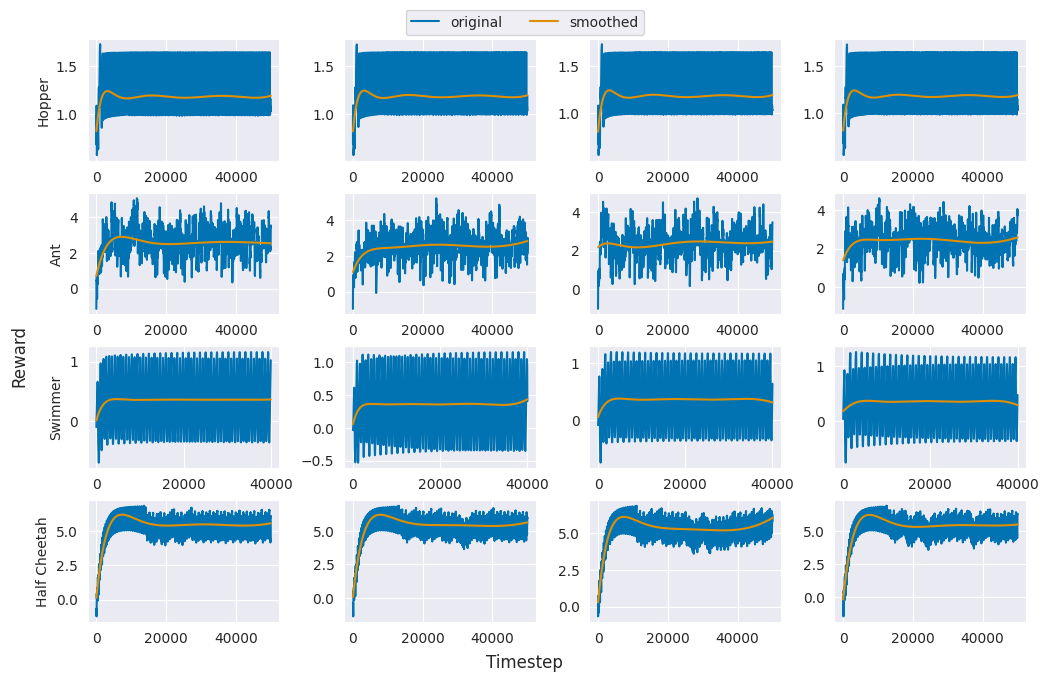

In [111]:
ncols = 4
nrows = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=set_size(doc_width_pt, 1.0, (nrows, ncols), use_golden_ratio=True), layout="constrained")

envs_to_check = ["hopper-v3", "ant-v3", "swimmer-v3", "cheetah-v3"]
for env_i, env_name in enumerate(envs_to_check):
    timesteps = 40000 if env_name == "swimmer-v3" else 50000
    data = np.load("./{}/{}/Rewards_{}_1000_8.npy".format("data", env_name, timesteps))
    smoothed_data = np.load("./{}/{}/Rewards_{}_1000_8-smoothed.npy".format("smoothed_data", env_name, timesteps))
    for traj_i in range(ncols):
        ax = axes[env_i, traj_i]
        ax.plot(data.T[traj_i], label="original" if traj_i == 0 and env_i == 0 else "")
        ax.plot(smoothed_data.T[traj_i], label="smoothed" if traj_i == 0 and env_i == 0 else "")
        if traj_i == 0:
            ax.set_ylabel(map_env[env_name])
fig.supylabel("Reward")
fig.supxlabel("Timestep")
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=4,
    borderaxespad=0.0,
    frameon=True,
    fontsize="10",
)
plt.savefig("smoothed_rewards.pdf", dpi=600, format="pdf", bbox_inches="tight")